## Docs

The following is a time-to-measure metric use to solve the following question: What is the expected time to reject the null hypothesis (background only) in the presence of one or both reactors? This can be modelled with a Poisson distribution with included errors on the background rate (assuming Gaussian errors).
$$\mathcal{L}(x,b|\hat{b},\sigma_b) = 
    b^xe^{-b}/x! \times 
    (2\pi\sigma_b^2)^{-1/2}\exp\left(-\frac{(b-\hat{b})^2)}{2\sigma_b^2} \right)
$$
Assuming flat uniform priors for $x$ and $b$, then a probability can be written as:
$$
\mathcal{P}(x|\hat{b},\sigma_b)=A\int_0^\infty\mathcal{L}(x,b|\hat{b},\sigma_b)db,
$$
where the normalization $A$ is defined such that
$$
\int_0^\infty\mathcal{P}(x)dx=1.
$$
To find the significance to reject the null hypothesis $\mathcal{P}(x)$, a measurent must observe a number of events $x_{th}$ or more, where $x_{th}$ is determined using the Feldman-Cousins ordering when integrating over possible values of $x$, at significance $\alpha$
$$
\alpha = \int_{FC}^{x_{th}}\mathcal{P}(x)dx
$$

In [3]:
from scipy.special import gamma, erf, erfinv
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('snoplus')

def savefig(fname):
    plt.savefig('figures/%s'%fname)
    print('Saving: ', fname)

class WatchmanLikelihood:
    '''
    Components for the counting likelihood.
    '''
    def __init__(self, **kwargs):
        self.cl = 3
    ## Helper functions
    
    def _cousins(self, x, f, alpha):
        f[x<0] = 0
        ss = f.argsort()[::-1]
        cc = p.cumsum(f[ss])
        cc = cc / np.max(cc)
        xlbound = np.min((x[ss])[cc<alpha])
        return xlbound, xrbound
    
    def _likelihood(self,s,b):
        f = (s)**b * np.e**(-(s)) / gamma(b+1)
        f = np.nan_to_num(f)
        return f
    
    def _sigma2cl(self, sigma):
        return erf(sigma/2**0.5)
    
    def _cl2sigma(self, cl):
        return erfinv(cl)*2**0.5

    def _cousinsZeroCl(self, x, f):
        f[x<0] = 0
        ss = f.argsort()[::-1]
        cc = np.cumsum(f[ss])
        cc = cc / np.max(cc)
        return np.min(cc[x[ss]<=0])

    def _cousinsRejectCl(self, x, f):
        return 1

In [2]:
'''
Here we consider the rejection of the null-hypothesis (background only) in the
presence of an 

Rewrite with rate.
'''

from scipy.special import gamma, erf, erfinv
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2
plt.style.use('snoplus')

def normal(x,mu):
    mu += 0.5 # for reasons
    s = (mu)**0.5
    return (2*np.pi*s**2)**-0.5*np.e**(-(x-mu)**2/2/s**2)

def poisson(x, mu):
    return mu**x*np.e**(-mu)/gamma(x+1)

def cousins(x, f, alpha):
    f[x<0] = 0
    ss = f.argsort()[::-1]
    cc = np.cumsum(f[ss])
    cc = cc / np.max(cc)
    xlbound = np.min((x[ss])[cc<alpha])
    xrbound = np.max((x[ss])[cc<alpha])
    return xlbound, xrbound


def likelihood(s,b,t):
    # t is the time, which scales everything, that way s and b are rate
    f  = poisson(s*t, b*t)
    f2 = normal(s*t, b*t)
    nan = np.where(np.isnan(f))
    inf = np.where(np.isinf(f))
    f[nan] = f2[nan]
    f[inf] = f2[inf]
    f = np.nan_to_num(f)
    return f

def fLikelihood(s, b, bhat, db, t):
    sv, bv = np.meshgrid(s, b)
    sv, bv = sv.T, bv.T
    ## We know ignore more than 6*sigma left, right
    bvL, bvR = bhat-6*(db**2+bhat)**0.5, bhat+6*(db**2+bhat)**0.5
    f = likelihood(sv, bv, t) * np.e**(-(bv-bhat)**2/2/db**2)
    #f[bv<bvL] = 0
    #f[bv>bvR] = 0
    f[f<0]=0
    f = np.nan_to_num(f)
    f[sv<0] = 0
    f[bv<0] = 0
    return f

def marginalize(fLike):
    ## Assume s, b
    marge = np.sum(fLike, axis=1)
    marge = marge / np.sum(marge)
    return marge

def sigma_to_cl(sigma):
    return erf(sigma/2**0.5)

def cl_to_sigma(cl):
    return erfinv(cl)*2**0.5

def cousins_zero_cl_bk(x, f):
    f[x<0] = 0
    ss = f.argsort()[::-1]
    cc = np.cumsum(f[ss])
    cc = cc / np.max(cc)
    return np.min(cc[x[ss]<=0])

def cousins_reject_cl(x, f, m):
    f[x<0] = 0
    ss = f.argsort()[::-1]
    cc = np.cumsum(f[ss])
    cc = cc / np.max(cc)
    return cc[x[ss]>=m][0]

def cousins_reject_cl_bk(x, f, m):
    ## cheat version
    cc = np.cumsum(f)
    cc = cc/np.max(cc)
    return cc[x>=m][0]

def cousins_reject_cl_bk(x, f, m):
    ## Wilks version
    fp = f/np.max(f)
    sig = (-2*np.log( fp[0] ))**0.5
    return sigma_to_cl(sig)
    
def jeremy(time, r, b, db):
    #return k1=k2
    return 2*time**0.5*(r-2*db)/((r+b-db)**0.5+(b+db)**0.5)
    #return 2*time**0.5*(r-2*db)/((b+db)**0.5+(r+b+db)**0.5)

def assym_no_error(time, signal, b):
    return (signal*time - 0.5)/(b*time+0.5)**0.5
    #return signal*(time/(b))**0.5

def assym_likelihood(time, signal, b):
    n = signal + b
    return (2*(n*time*np.log(n/b)+b*time-n*time))**0.5

def assym_likelihood_error(time, signal, background, db):
    vals = []
    f = lambda s, b, db, t: (s+b)**(signal*t+background*t)/(gamma(signal*t+background*t+1))*np.e**(-(s+b))*\
        np.e**(-(b-background*t)**2/2/db**2)
    
    svec = np.linspace(0,10,1001)
    bvec = np.linspace(0,10,1001)
    ss, bb = np.meshgrid(svec, bvec)
    ss, bb = ss.T, bb.T
    
    for d in time:
        ftop = f(0, bvec*d, db*d, d)
        ftop[np.isnan(ftop)]=0
        ftop[np.isinf(ftop)]=0
        
        fbot = f(signal*d, bvec*d, db*d, d)
        fbot[np.isnan(fbot)]=0
        fbot[np.isinf(fbot)]=0
        
        ftop = np.sum(ftop)
        fbot = np.sum(fbot)

        lrat = ftop/fbot
        vals.append((-2*np.log(lrat))**0.5)
    return np.array(vals)

def assym_error(time, signal, b, db):
    return (signal*time - 0.5)/(b*time+0.5+(db*time)**2)**0.5
    #return (signal*time)/(b*time+(db*time)**2)**0.5

def poisson_plot(s, b, **kwargs):
    livetime = kwargs.get('livetime', 15)
    yscale = kwargs.get('yscale', 'linear')
    xscale = kwargs.get('xscale', 'linear')
    e_list = kwargs.get('e_list', np.array([0.02, 0.1, 0.2, 0.4, 0.6]))

    bkg = b * livetime
    measure = (s+b) * livetime
    
    short = np.linspace(0,5,11)
    long = np.linspace(5,40,36)
    days = np.concatenate([short, long])
    days = kwargs.get('days', days)
    #days = np.logspace(0,4,100)

    print('For %0.1f days, the bkg is %0.2f, with %0.2f measured events'%(livetime,bkg,measure))
    print('This is for a rate of b=%0.2f, s=%0.2f, m=%0.2f'%
          (bkg/livetime, (measure-bkg)/livetime, (measure/livetime)))

    error = 0.8

    x = np.linspace(0,10,1001)
    bg_uncertainty = error * b
    xe = np.linspace(-bg_uncertainty*6, bg_uncertainty*6, 1001)
    prob = likelihood(x, b, livetime)
    prob = prob/np.sum(prob)
    full_prob = fLikelihood(x, x, b, bg_uncertainty, livetime)
    mg = marginalize(full_prob)
    ## Test

    def clrwheel():
        clrs = ['xkcd:aqua', 'xkcd:indigo', 'xkcd:salmon', 'xkcd:olive', 'xkcd:dark teal']
        while True:
            for c in clrs:
                yield c

    cc = np.cumsum(prob)
    cc = cc/np.max(cc)

    print('MLE: %0.3f' % x[np.argmax(prob)])

    xmin, xmax = 0, 10

    plt.plot(x, prob, color='red', label='No Error')
    print('mg sum', np.sum(mg))
    plt.plot(x, mg, label='$\sigma$=%0.2f'%(bg_uncertainty))
    #plt.title('Conf: %0.2f'%confidence)
    #plt.axvline(measure)
    #plt.fill_between(x, prob, where=(x>=xl)&(x<=xr), color='blue', alpha=0.3)
    plt.xlim(xmin,xmax)
    plt.ylim(bottom=0)
    #plt.yscale('log')
    plt.xlabel('Measured events $x$')
    plt.ylabel('$\mathcal{P}(x)$')
    plt.legend()
    plt.show()

    # Delta Log-Likelihoodmeasure_nom
    dll = -2*np.log(prob)
    dll = dll - np.min(dll)
    plt.plot(x, dll)
    plt.axvline(s+b)
    xl, xr = cousins(x, prob, sigma_to_cl(3))
    xl1, xr1 = cousins(x, prob, sigma_to_cl(1))
    xl2, xr2 = cousins(x, prob, sigma_to_cl(2))
    plt.axvspan(xl, xr, alpha=0.1, color='purple')
    plt.axvspan(xl2, xr2, alpha=0.1, color='green')
    plt.axvspan(xl1, xr1, alpha=0.1, color='red')
    plt.ylim(0, 15)
    plt.xlim(xmin, xmax)
    plt.xlabel('Measured events $x$')
    plt.ylabel('-2Ln$\mathcal{P}(x)$')
    plt.show()

    # Sigma(days)

    k = []
    mK = []
    ## Some others, maybe error_list of 0.2, 0.4, 0.6
    
    mK = [[] for e in e_list]

    for d in days:
        m = s+b
        pb = likelihood(x, b, d)
        k.append( cl_to_sigma(cousins_reject_cl(x,pb,m)) )
        ## Margen.
        for e in range(len(e_list)):
            marg_pb = marginalize(fLikelihood(x, x, b, e_list[e]*b, d))
            mK[e].append( cl_to_sigma(cousins_reject_cl(x, marg_pb, m)) )

    k = np.array(k)
    mK = np.array(mK)

    plt.plot(days, assym_no_error(days,s,b), 
             color='black', dashes=[4,2])
    plt.plot(days, assym_likelihood(days,s, b),
             color='black')
    clines = clrwheel()
    #plt.plot(days, k, '.', label='No error', color='black')
    for e,m in zip(e_list, mK):
        cuse = next(clines)
        #plt.plot(days, m, '.', label='%0.1f%% error'%(e*100), color=cuse)
        plt.plot(days, assym_error(days,s,b,e*b), color=cuse, dashes=[4,2])
        plt.plot(days, assym_likelihood_error(days,s,b,e*b), color=cuse, label='%0.1f%% error'%(e*100))


    #for s,c in zip(range(1,6), clrs):
    #     try:
    #         plt.vlines(days[k>=s][0], 0, s, label='%i $\sigma$ [%0.2f days]'%(s,days[k>=s][0]), color=c)
    #     except:
    #         pass
    plt.xlim(1, np.max(days))
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.ylim(bottom=5e-1)
    plt.ylabel('$\sigma$ to reject the null')
    plt.xlabel('Days')
    plt.legend()
    plt.grid()
    plt.savefig('SensitivityComparison.pdf')
    plt.show()

    for e,m in zip(e_list,mK):
        clrs = ['xkcd:orange', 'xkcd:green', 'xkcd:teal', 'xkcd:violet', 'xkcd:magenta']

        fig, axs = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios':[4,1]})
        axs[0].set_title('Error: %0.2f -- SNR: %0.2f'%(e,(measure-bkg)/bkg))
        axs[0].grid()
        axs[0].plot(days, m, label='Poisson')
        j = jeremy(days, s, b, e*b)
        axs[0].plot(days, j,
                    label='analytic')
        axs[0].set_xlim(0, np.max(days))
        axs[0].set_ylim(bottom=0)
        axs[0].set_ylabel('$\sigma$ to reject the null')
        axs[0].legend()
        axs[1].plot(days, m/j, color='xkcd:maroon')
        axs[1].grid()
        axs[1].set_xlabel('Days')
        fig.subplots_adjust(hspace=0)
        plt.show()

    # Now lets include an uncertainty on the background and margenalize


For 2.0 days, the bkg is 0.80, with 3.54 measured events
This is for a rate of b=0.40, s=1.37, m=1.77
MLE: 0.130
mg sum 0.9999999999999999


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Nimbus Roman Italic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


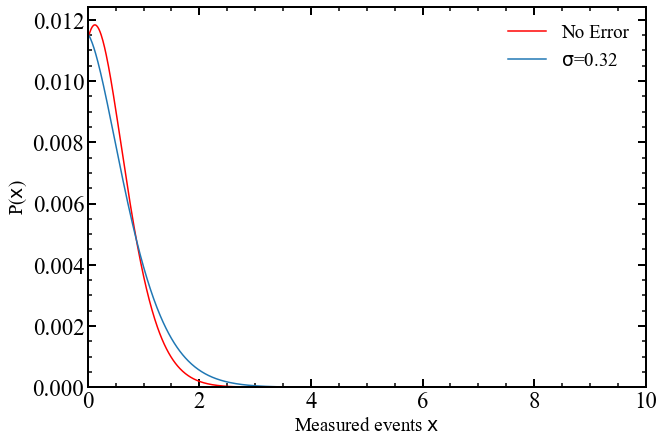

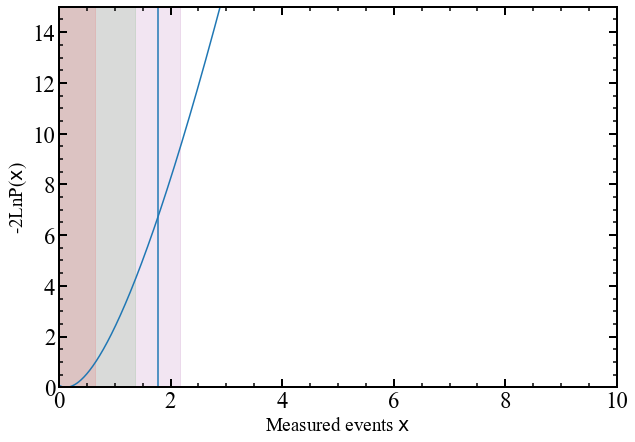

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in power
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in double_scalars


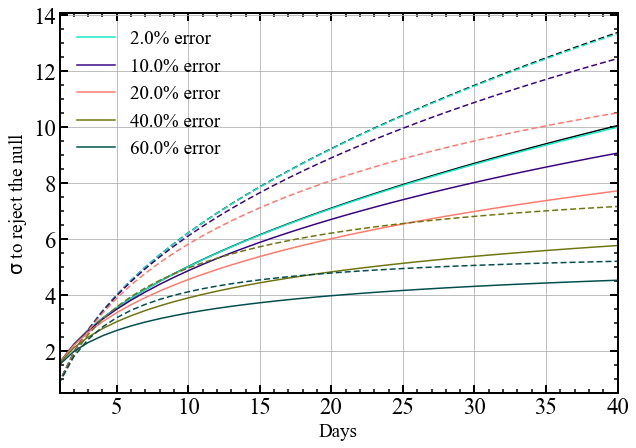

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:275: RuntimeWarning: divide by zero encountered in true_divide


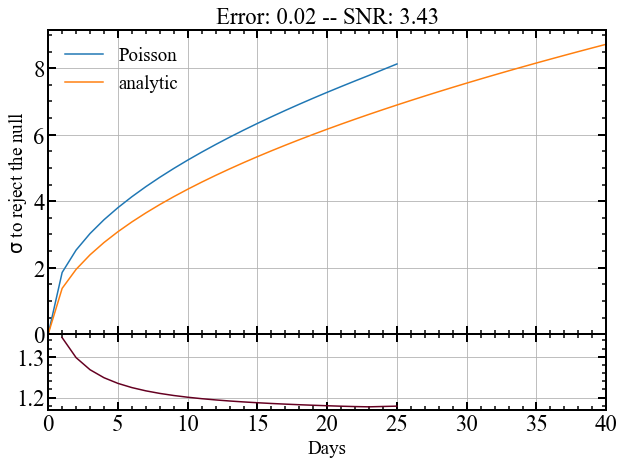

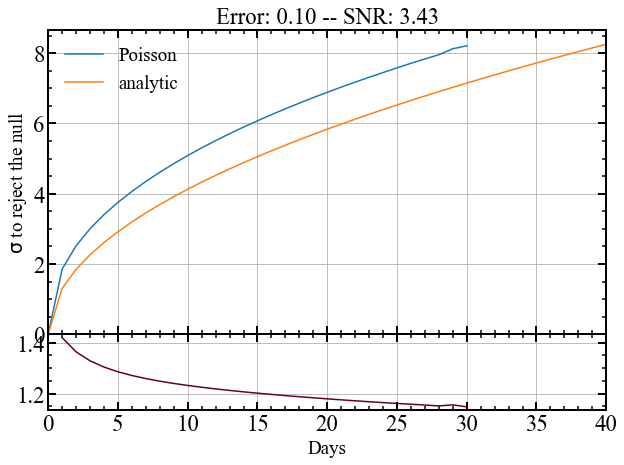

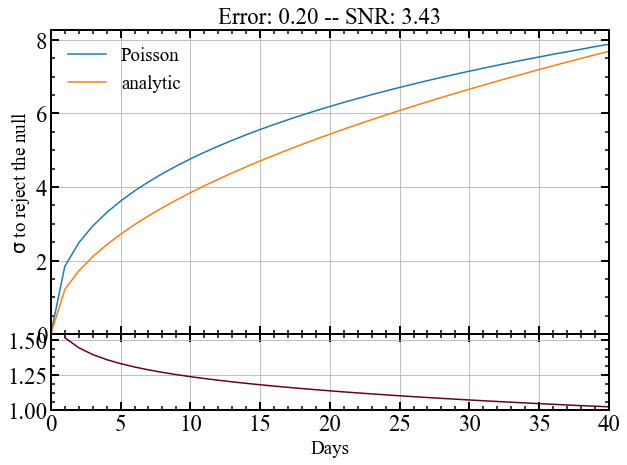

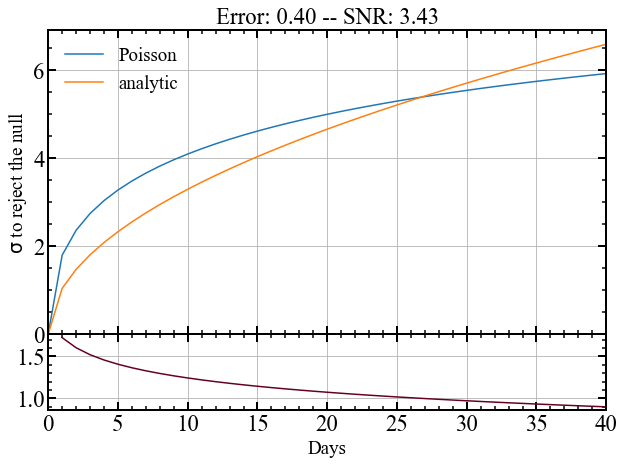

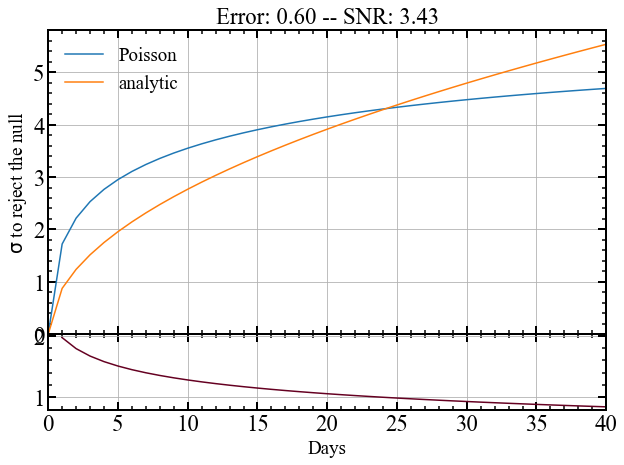

In [4]:
b = (2.8)/7
s = (4.8+4.8)/7
lt = 2 #days
days = np.linspace(0,40,41)

poisson_plot(s, b, livetime=lt, days=days)

For 3.0 days, the bkg is 4.89, with 5.91 measured events
This is for a rate of b=1.63, s=0.34, m=1.97
MLE: 1.460
mg sum 1.0


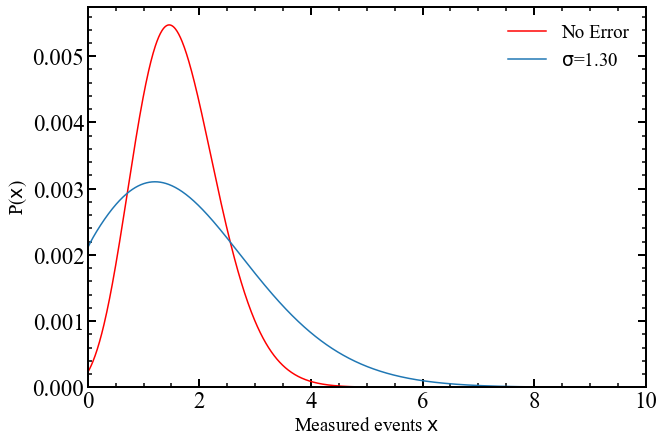

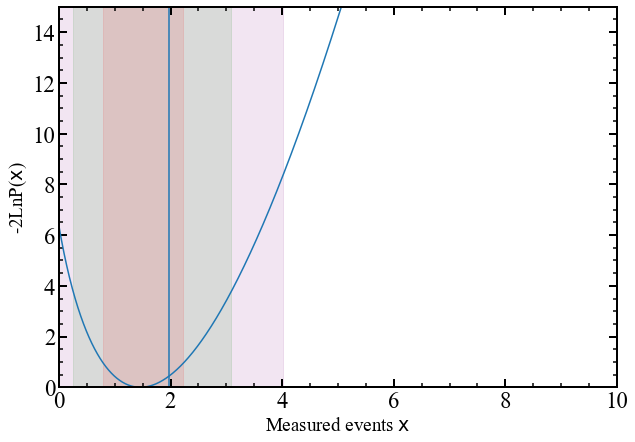

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in power
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: overflow encountered in power
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encou

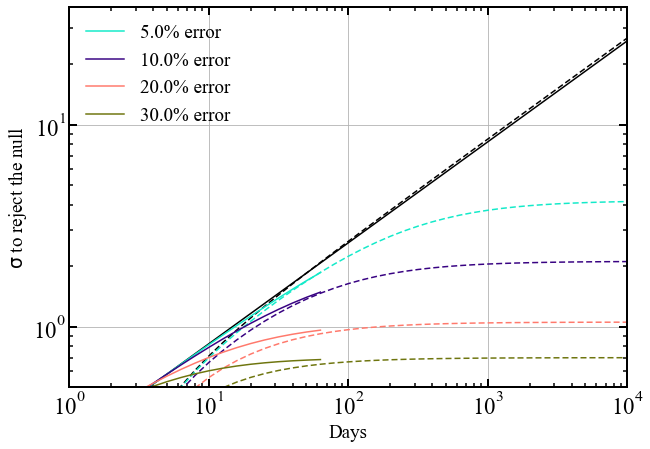

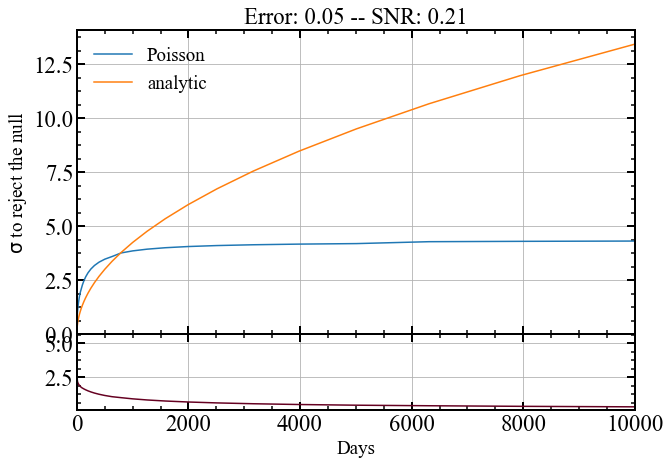

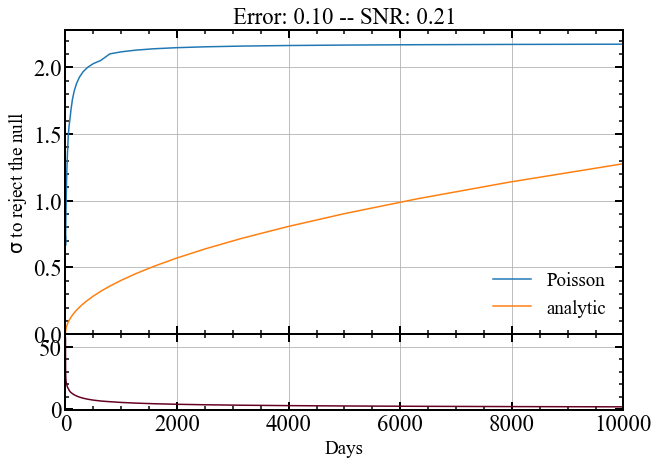

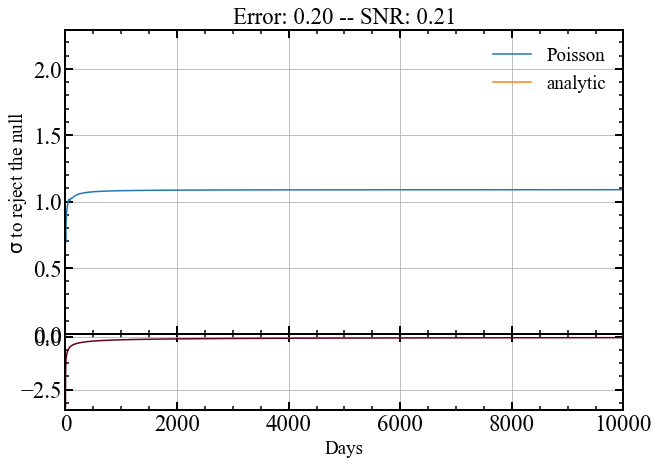

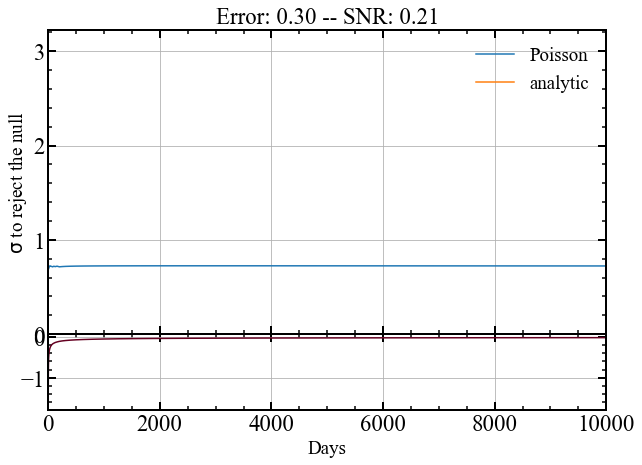

In [23]:
b = (2.8+4.8)/7*1.5
s = (4.8)/7/2.
lt = 3 #days
days = np.logspace(0,4,41)
e_list = np.array([0.05, 0.10, 0.2, 0.3])

poisson_plot(s, b, livetime=lt, days=days, xscale='log', yscale='log', e_list=e_list)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


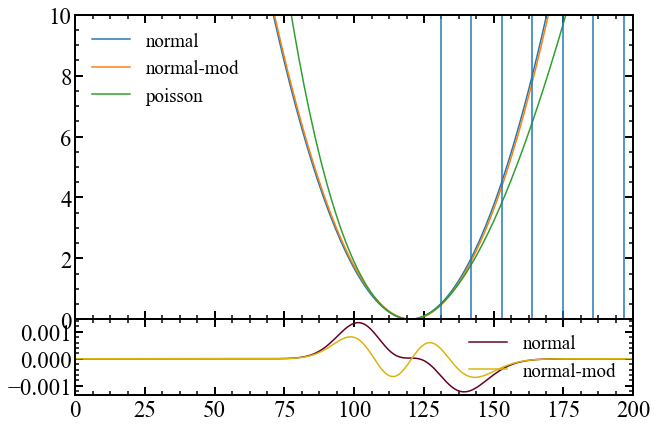

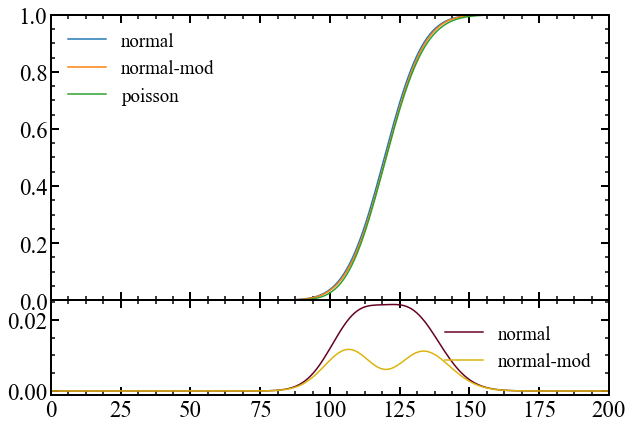

In [159]:
￼'''
For the Poisson distribution above I 
likely need a smooth transition to the normal approximation,
this is a test of that transition
'''
from scipy.special import gamma
def normal(x,mu):
    s = (mu)**0.5
    return (2*np.pi*s**2)**-0.5*np.e**(-(x-mu)**2/2/s**2)

def poisson(x, mu):
    return x**mu*np.e**(-x)/gamma(mu+1)

mu = 120
xmax = 200
x = np.linspace(0, xmax, 201)
xsig = np.array([1,2,3,4,5,6,7,8])*mu**0.5+mu

fishy = poisson(x, mu)
normy = normal(x, mu)
nmod = normal(x, mu+0.5)
fig, axs = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios':[4,1]})
axs[0].plot(x, -np.log(normy/np.max(normy)), label='normal')
axs[0].plot(x, -np.log(nmod/np.max(nmod)), label='normal-mod')
axs[0].plot(x, -np.log(fishy/np.max(fishy)), label='poisson')
axs[0].legend()
axs[0].set_xlim(0,xmax)
axs[0].set_ylim(0,10)
#axs[0].set_yscale('log')
#axs[0].set_ylim(1e-4, 1)
for xs in xsig:
    axs[0].axvline(xs)

axs[1].plot(x, normy-fishy, color='xkcd:maroon', label='normal')
axs[1].plot(x, nmod-fishy, color='xkcd:gold', label='normal-mod')
#axs[1].set_ylim(-0.003, 0.003)
axs[1].legend(loc='right')

fig.subplots_adjust(hspace=0)
plt.show()

## repeat for cdf
def cdf(f):
    cc = np.cumsum(f)
    cc = cc / np.max(cc)
    return cc

cfish = cdf(fishy)
cnorm = cdf(normy)
cmod = cdf(nmod)

fig, axs = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios':[3,1]})
axs[0].plot(x, cnorm, label='normal')
axs[0].plot(x, cmod, label='normal-mod')
axs[0].plot(x, cfish, label='poisson')
axs[0].legend()
axs[0].set_xlim(0,xmax)
axs[0].set_ylim(0, 1)

axs[1].plot(x, cnorm-cfish, color='xkcd:maroon', label='normal')
axs[1].plot(x, cmod-cfish, color='xkcd:gold', label='normal-mod')
#axs[1].set_ylim(-0.003, 0.003)
axs[1].legend(loc='right')

fig.subplots_adjust(hspace=0)
plt.show()

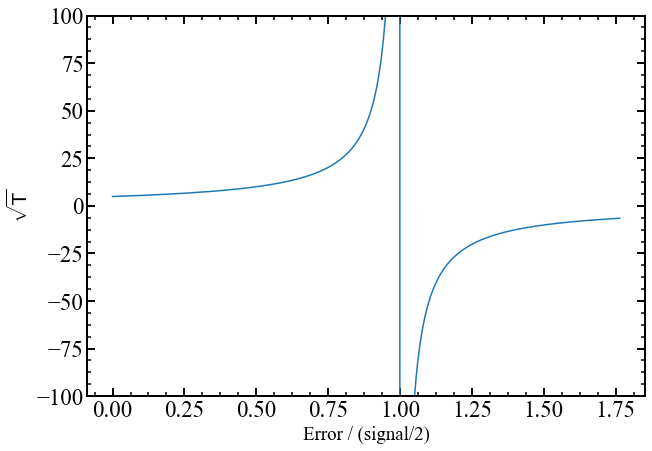

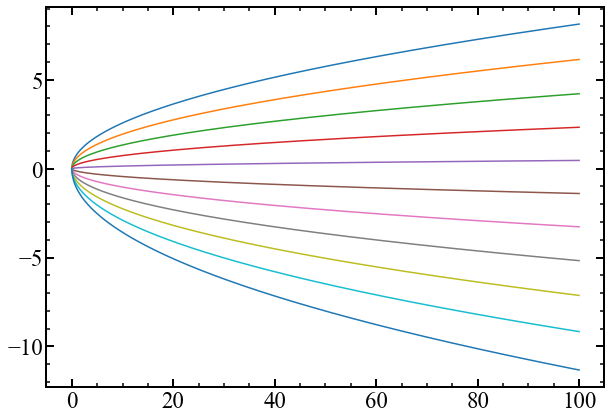

In [14]:
## Jeremy
def j(r, b, db, k):
    # k1=k2=k
    bhi = b+db
    blo = b-db
    return (k*bhi**0.5+k*(r+blo)**0.5)/(r-(bhi-blo))

def j_inv(time, r, b, db):
    #return k1=k2
    return 2*time**0.5*(r-2*db)/((r+b-db)**0.5+(b+db)**0.5)

## Two things to plot, root_t vs db, then k vs T
# signal to noise:
snr = 1.7

b = 2.8/7
s = b*snr

db = np.linspace(0,1.5,1001)*b
plt.plot(db/(s/2), j(s, b, db, 2),
        label='$$'
        )
plt.xlabel('Error / (signal/2)')
plt.ylim(-100, 100)
plt.ylabel('$\sqrt{T}$')
plt.show()

T = np.linspace(0,100,1001)
bset = np.linspace(0,2,11)
for bb in bset:
    plt.plot(T, j_inv(T, s, b, bb*b))
plt.show()

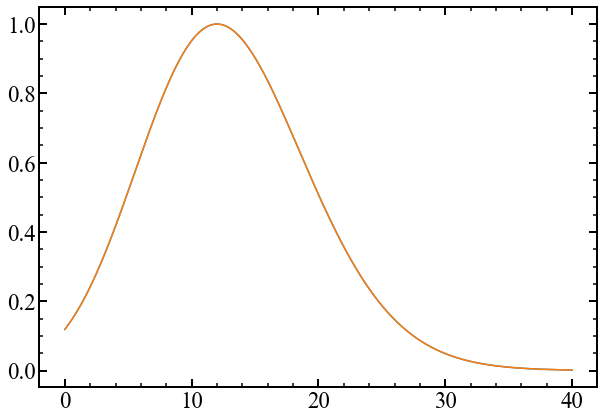

In [10]:
def pratio(s,b,n):
    return ((s+b)/b)**n*np.e**(-s)

def h1(s,b,n):
    return (s+b)**n*np.e**(-(s+b))/gamma(n+1)

b = 30
n = b + 12
x = np.linspace(0,40,1001)
f1 = pratio(x,b,n)
f1 = f1/np.max(f1)
plt.plot(x, f1)
f2 = h1(x, b, n)
f2 = f2/np.max(f2)
plt.plot(x, f2)
plt.show()

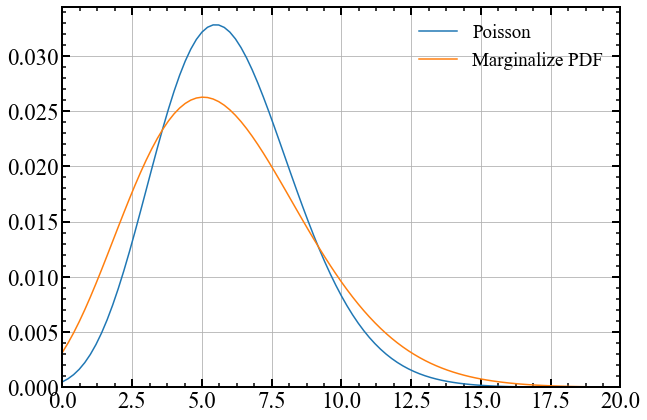

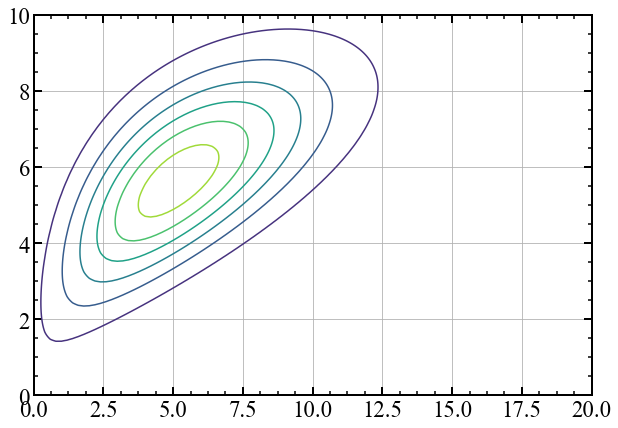

In [100]:
def poisson(x, b):
    return b**x*np.e**(-b)/gamma(x+1)

def constraint(b, bhat, s):
    return (2*np.pi*s**2)**(-0.5)*np.e**(-(b-bhat)**2/2/s**2)

def likelihood(x, b, bhat, s):
    # x and b are vectors
    xx, bb = np.meshgrid(x, b)
    X, B = xx.T, bb.T
    return poisson(X, B)*constraint(B, bhat, s)

def marginalize(likelihoodFunction, axis):
    marge = np.sum(likelihoodFunction, axis=axis)
    marge /= np.sum(marge)
    return marge
    
x = np.linspace(0,20, 101)
b = np.linspace(0,10, 1001)

bhat = 6
bsig = 2

likelihood_function = poisson(x, bhat)
# Normalize the likelihood_function
likelihood_function /= np.sum(likelihood_function)
plt.plot(x, likelihood_function, label='Poisson')

Z = likelihood(x, b, bhat, bsig)
marginal_likelihood = marginalize(Z, 1)

plt.plot(x, marginal_likelihood, label='Marginalize PDF')
plt.xlim(0,20)
plt.ylim(bottom=0)
plt.grid()
plt.legend()
plt.show()

xx, bb = np.meshgrid(x, b)
X, B, Z = xx.T, bb.T, Z/np.max(Z)
plt.contour(X,B,Z)
plt.grid()
plt.show()

(1001, 101)
101


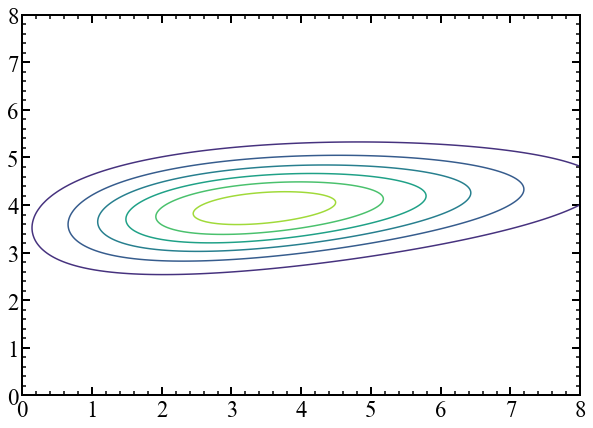

(101,)
0.6065306597126334
0.1353352832366127
0.01110899653824231


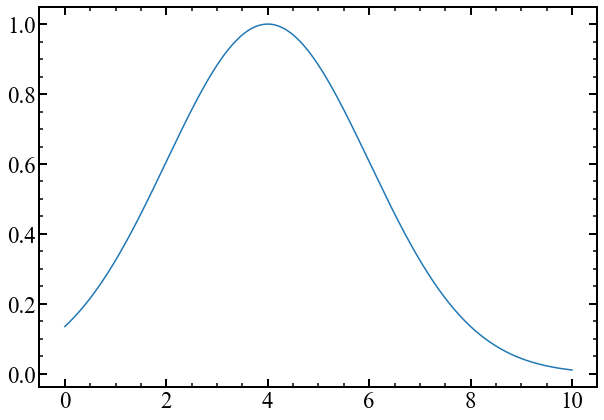

In [85]:
### TEST
def f(x, y):
    #return np.e**(-(x-y)**2) * np.e**(-(y-4)**2)
    return y**x*np.e**(-y)/gamma(x+1) * np.e**(-(y-4)**2)

x = np.linspace(0, 8, 101)
y = np.linspace(0, 8, 1001)

xx, yy = np.meshgrid(x, y)
print(xx.shape)
X, Y = xx.T, yy.T
## Do i need to transpose?
zz = f(X, Y)
print(zz.shape[0])
plt.contour(X, Y, zz)
plt.show()

h = np.sum(zz, axis=1)
print(h.shape)

j = lambda x, mu, s: np.e**(-(x-mu)**2/2/s**2)
q = np.linspace(0,10,1001)
print(j(6,4,2))
print(j(8,4,2))
print(j(10,4,2))
plt.plot(q, j(q, 4, 2))
plt.show()

# Old

0.0 14.200000000000003
MLE: 4.100
s90: 14.300


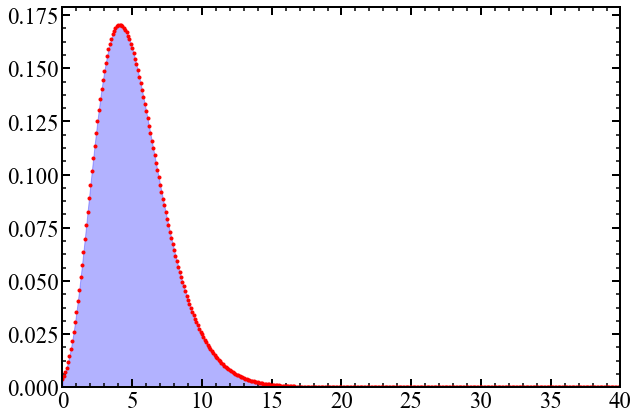

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log
/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Nimbus Roman Italic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman Bold'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


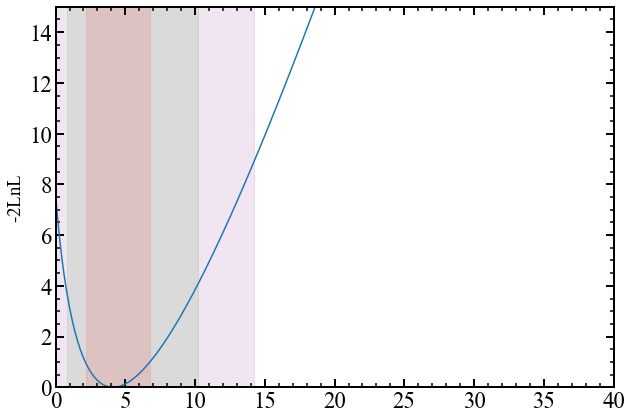

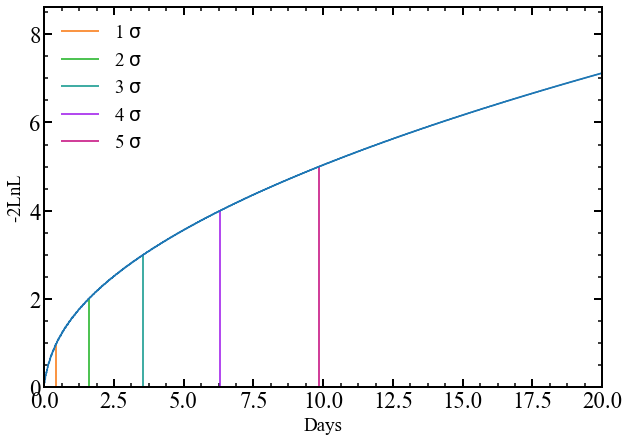

In [2]:
'''
The following is a poisson likelihood for measuring a signal in the presence of a
known background.
'''
from scipy.special import gamma, erf, erfinv
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('snoplus')

bkg_nom = (2.8)/7.
measure_nom = bkg_nom+(4.8*2)/7.
livetime = 3 # week

# Test
#bkg_nom = (2.8+4.8)/7
#measure_nom = bkg_nom + 4.8/7

bkg = bkg_nom * livetime
measure = measure_nom * livetime
cl = 3 #sigma

def cumulative(x, f, alpha):
    # s >= 0 prior
    f[x<0] = 0
    # bin-normalize
    f = f / np.sum(f)
    # cumulative
    c = np.cumsum(f)
    return x[c>alpha][0]

def cousins(x, f, alpha):
    f[x<0] = 0
    ss = f.argsort()[::-1]
    cc = np.cumsum(f[ss])
    cc = cc / np.max(cc)
    xlbound = np.min((x[ss])[cc<alpha])
    xrbound = np.max((x[ss])[cc<alpha])
    return xlbound, xrbound

def likelihood(s,b,n):
    a = s+b
    a[a<0]=0
    return (a)**n * np.e**(-(a)) / gamma(n+1)

def sigma_to_cl(sigma):
    return erf(sigma/2**0.5)

def cl_to_sigma(cl):
    return erfinv(cl)*2**0.5

def cousins_zero_cl(x, f):
    f[x<0] = 0
    ss = f.argsort()[::-1]
    cc = np.cumsum(f[ss])
    cc = cc / np.max(cc)
    return np.min(cc[x[ss]<=0])
    

x = np.linspace(-10,300,3101)
prob = likelihood(x, bkg, measure)
xl, xr = cousins(x, prob, sigma_to_cl(cl))
print(xl, xr)

print('MLE: %0.3f' % x[np.argmax(prob)])
print('s90: %0.3f' % s90)

xmin, xmax = 0, 40

plt.plot(x, prob, '.', color='red')
plt.fill_between(x, prob, where=(x>=xl)&(x<=xr), color='blue', alpha=0.3)
plt.xlim(xmin,xmax)
plt.ylim(bottom=0)
plt.show()

# Delta Log-Likelihood
dll = -2*np.log(prob)
dll = dll - np.min(dll)
plt.plot(x, dll)
xl1, xr1 = cousins(x, prob, sigma_to_cl(1))
xl2, xr2 = cousins(x, prob, sigma_to_cl(2))
plt.axvspan(xl, xr, alpha=0.1, color='purple')
plt.axvspan(xl2, xr2, alpha=0.1, color='green')
plt.axvspan(xl1, xr1, alpha=0.1, color='red')
plt.ylim(0, 15)
plt.xlim(xmin, xmax)
plt.ylabel('-2Ln$\mathcal{L}$')
plt.show()

# Sigma(days)
days = np.linspace(0,30,3001)
k = []
for d in days:
    b = bkg_nom * d
    m = measure_nom * d
    pb = likelihood(x, b, m)
    k.append( cl_to_sigma(cousins_zero_cl(x,pb)) )
k = np.array(k)

plt.plot(days, k)

clrs = ['xkcd:orange', 'xkcd:green', 'xkcd:teal', 'xkcd:violet', 'xkcd:magenta']
for s,c in zip(range(1,6), clrs):
    plt.vlines(days[k>=s][0], 0, s, label='%i $\sigma$'%s, color=c)
plt.xlim(0, 20)
plt.ylim(bottom=0)
plt.ylabel('-2Ln$\mathcal{L}$')
plt.xlabel('Days')
plt.legend()
plt.show()

# Now lets include an uncertainty on the background and margenalize
def full_likelihood(s,b,n,d):
    #d is uncertainty on b
    a = s+b
    a[a<0]=0
    return (a)**n * np.e**(-(a)) / gamma(n+1)